<a href="https://colab.research.google.com/github/moh53/Graduation-Project-FMS/blob/NN-models/vgg16_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**import the dataset from kaggle**

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lumayasir","key":"3b1f5beae653ce69d5bd5670138b2b60"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.09G/3.10G [00:52<00:00, 30.7MB/s]
100% 3.10G/3.10G [00:52<00:00, 63.3MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "breast-histopathology-images.zip"

with ZipFile(file_name, 'r')as zip:
  data= zip.extractall()
  print('Done')

Done


**Import Libraries**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tarfile

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision import transforms
from collections import Counter

import torchvision .transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import WeightedRandomSampler

**Load Images**

In [ ]:
# Load all image data
data_dir = os.getcwd()
folder_name = "IDC_regular_ps50_idx5"
image_folders = os.path.join(data_dir, folder_name)

transform = transforms.Compose([transforms.Resize((50, 50)), transforms.ToTensor()])
images = []
for file in os.listdir(image_folders):
    images.append(ImageFolder(os.path.join(image_folders, file), transform=transform))
datasets = torch.utils.data.ConcatDataset(images)

In [ ]:
# Determine the number of samples for each class
i=0
for dataset in datasets.datasets:
    if i==0:
        result = Counter(dataset.targets)
        i += 1
    else:
        result += Counter(dataset.targets)

result = dict(result)
print("""Total Number of Images for each Class:
    Class 0 (No Breast Cancer): {}
    Class 1 (Breast Cancer present): {}""".format(result[0], result[1]))

In [ ]:
# Pie chart (Number of Samples For Each Class)
labels = "0: benign (No Cancer)", "1: malignant (Have Cancer)"
total = result[0] + result[1]
sizes = [result[0]/total, result[1]/total]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Number of Samples by Class")
plt.show()
plt.savefig("number_of_samples_breakdown")

**Split Data to Train, Validation and Test Set**

In [ ]:
# Prepare data for training, validation and test
random_seed = 42
torch.manual_seed(random_seed)

test_size = 38000
train_size = len(datasets) - test_size
train_ds, test_ds = random_split(datasets, [train_size, test_size])

val_size = 38000
train_size = len(train_ds) - val_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size])

len(train_ds), len(val_ds), len(test_ds)

(201524, 38000, 38000)

In [ ]:
train_data = DataLoader(train_ds, shuffle=True, num_workers=4, pin_memory=True)
val_data = DataLoader(val_ds, shuffle=True, num_workers=4, pin_memory=True)
test_data = DataLoader(test_ds, shuffle=True, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# Save Train, Validation and Test Data
def save_data(data, mode="train"):
    i = 0
    for img, label in data:
        folder_path = os.path.join(os.path.join(os.getcwd(), mode), str(np.array(label)[0]))
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        i += 1
        image = transforms.ToPILImage()(img[0, :, :, :])
        image.save(os.path.join(folder_path, mode+"_"+str(i)+".jpg"), "JPEG")

In [ ]:
# Save Train Data
save_data(train_data, mode="train")

# Save Validation Data
save_data(val_data, mode="validation")

# Save Test Data
save_data(test_data, mode="test")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**Load the Data & Prepare the Data For Training**

In [ ]:
img_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.8132459, 0.634275, 0.7334242), (0.0913294, 0.14485621, 0.107605696) )
    ])

img_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),    
    transforms.ToTensor(),
    transforms.Normalize((0.8132459, 0.634275, 0.7334242), (0.0913294, 0.14485621, 0.107605696) )
    ])

In [ ]:
train_tfms = img_transforms
valid_tfms = img_test_transforms

**Oversampling**

In [ ]:
def get_loader(batch_size):
    data_dir = os.getcwd()
    train_file = os.path.join(data_dir, "train")
    train_ds = ImageFolder(train_file, train_tfms)
    class_weights = [1, 2.5]
    sample_weights = [0] * len(train_ds)

    for idx, (data, label) in enumerate(train_ds):
        class_weight = class_weights[label]
        sample_weights[idx] = class_weight

    sampler = WeightedRandomSampler(sample_weights, num_samples= len(sample_weights), replacement= True)
    train_loader = DataLoader(train_ds, batch_size= batch_size, sampler=sampler)
    return train_loader

In [ ]:
train_loader = get_loader(64)

In [ ]:
num_posative = 0
num_negative = 0
for data, label in train_loader:
    num_negative += torch.sum(label==0)
    num_posative += torch.sum(label==1)
print(num_negative)
print(num_posative)

tensor(101655)
tensor(99869)


In [ ]:
# Load train, validation and test dataset
data_dir = os.getcwd()

val_file = os.path.join(data_dir, "validation")
test_file = os.path.join(data_dir, "test")


val_ds = ImageFolder(val_file, valid_tfms)
test_ds = ImageFolder(test_file, valid_tfms)

In [ ]:
class_weights = [1, 3]
sample_weights = [0] * len(val_ds)
for idx, (data, label) in enumerate(val_ds):
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight
sampler = WeightedRandomSampler(sample_weights, num_samples= len(sample_weights), replacement= True)
val_data = DataLoader(val_ds, batch_size= 64, sampler=sampler)

In [ ]:
num_posative = 0
num_negative = 0
for data, label in val_data:
    num_negative += torch.sum(label==0)
    num_posative += torch.sum(label==1)
print(num_negative)
print(num_posative)

In [ ]:
class_weights = [1, 3]
sample_weights = [0] * len(test_ds)
for idx, (data, label) in enumerate(test_ds):
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight
sampler = WeightedRandomSampler(sample_weights, num_samples= len(sample_weights), replacement= True)
test_data = DataLoader(test_ds, batch_size= 64, sampler=sampler)

In [ ]:
num_posative = 0
num_negative = 0
for data, label in test_data:
    num_negative += torch.sum(label==0)
    num_posative += torch.sum(label==1)
print(num_negative)
print(num_posative)

**import the pretrained model and save the weight**

In [ ]:

import torch.onnx as onnx
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
vgg16 = models.vgg16(pretrained=True)
torch.save(vgg16.state_dict(), 'model_weights.pth')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**modify the last layer**

In [ ]:
# change the number of classes 
vgg16.classifier[6].out_features = 2
# freeze convolution weights
for param in vgg16.features.parameters():
    param.requires_grad = False

In [ ]:
from torch import optim
# optimizer
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.001)
# loss function
criterion = nn.CrossEntropyLoss()
model = vgg16.to(device)

**Train the Model**

In [ ]:
n_epochs = 1
print_every = 100
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        
        data_ = data_.to(device)
        target_ = target_.to(device)
        #batch_idx = batch_idx.to(device)  #this will move inout to your device        
        #batch = batch.to(device)  #this will move inout to your device        

        optimizer.zero_grad()
        
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 200 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (val_data):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(val_data))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    model.train()

Epoch 1



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/1], Step [0/3149], Loss: 8.1465
Epoch [1/1], Step [200/3149], Loss: 0.4581
Epoch [1/1], Step [400/3149], Loss: 0.3820
Epoch [1/1], Step [600/3149], Loss: 0.3281
Epoch [1/1], Step [800/3149], Loss: 0.3532
Epoch [1/1], Step [1000/3149], Loss: 0.3022
Epoch [1/1], Step [1200/3149], Loss: 0.5632
Epoch [1/1], Step [1400/3149], Loss: 0.3014
Epoch [1/1], Step [1600/3149], Loss: 0.4486
Epoch [1/1], Step [1800/3149], Loss: 0.4197
Epoch [1/1], Step [2000/3149], Loss: 0.4683
Epoch [1/1], Step [2200/3149], Loss: 0.3996
Epoch [1/1], Step [2400/3149], Loss: 0.3453
Epoch [1/1], Step [2600/3149], Loss: 0.2643
Epoch [1/1], Step [2800/3149], Loss: 0.4542
Epoch [1/1], Step [3000/3149], Loss: 0.3730

train-loss: 0.4343, train-acc: 82.2587
validation loss: 0.3941, validation acc: 83.8368

Improvement-Detected, save-model


In [ ]:

#saving the model
import
#model = Model()
torch.save(model,'/content/my_vgg16.h5')

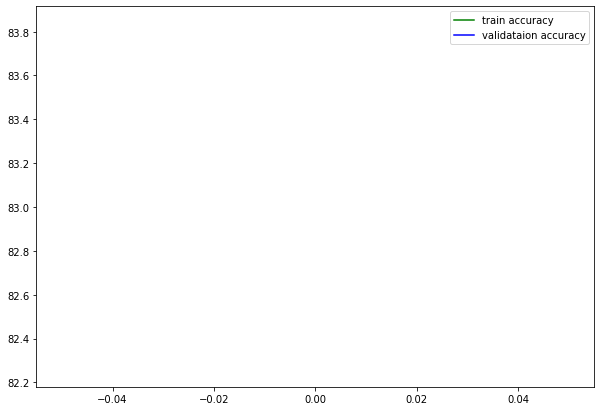

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_acc, color='green', label='train accuracy')
plt.plot(val_acc, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()


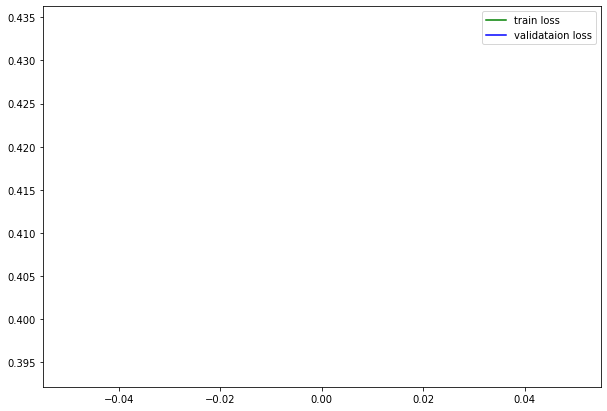

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='green', label='train loss')
plt.plot(val_loss, color='blue', label='validataion loss')
plt.legend()
plt.savefig('loss.png')
plt.show()


**Test the trained model**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

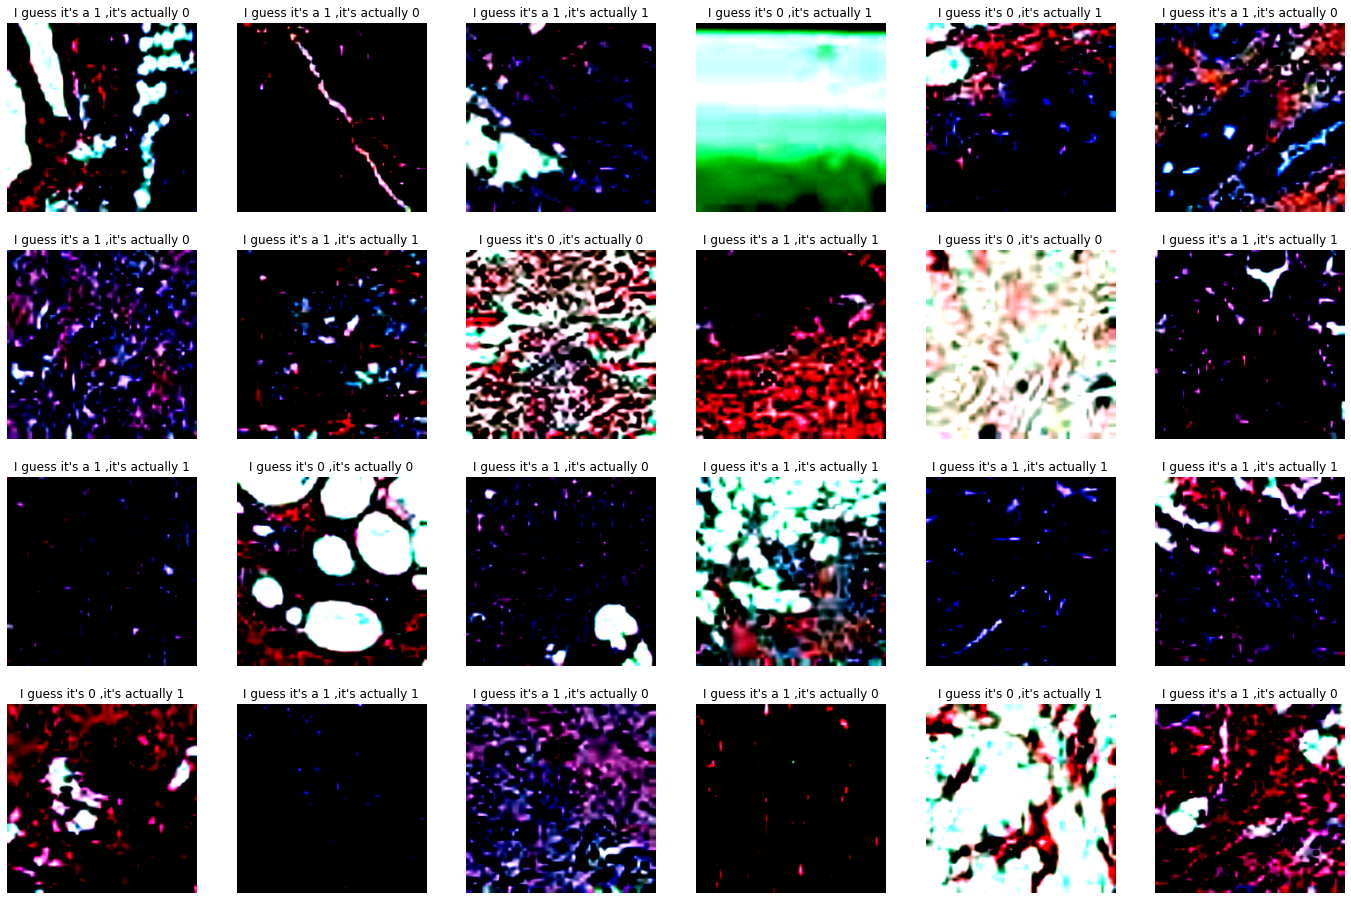

In [ ]:
img, label = iter(test_data).next()
samples, _ = iter(test_data).next() 
samples = samples.to('cuda:0')
fig = plt.figure(figsize=(24, 16)) 
fig.tight_layout() 
output = model(samples[:24])
labelss= label.numpy() 
pred = torch.argmax(output, dim=1) 
pred = [p.item() for p in pred] 
ad = {0:'I guess it\'s 0', 1:'I guess it\'s a 1'}
ads = {0:' ,it\'s actually 0',1: ' ,it\'s actually 1'} 
for num, sample in enumerate(samples[:24]): 
    plt.subplot(4,6,num+1) 
    plt.title(ad[pred[num]] + ads[labelss[num]])
    plt.axis('off') 
    sample = sample.cpu().numpy() 
    plt.imshow(np.transpose(sample, (1,2,0)))

In [ ]:
n_epochs = 50
print_every = 100
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        
        data_ = data_.to(device)
        target_ = target_.to(device)
        #batch_idx = batch_idx.to(device)  #this will move inout to your device        
        #batch = batch.to(device)  #this will move inout to your device        

        optimizer.zero_grad()
        
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 200 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (val_data):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(val_data))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    model.train()

Epoch 1



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/50], Step [0/2016], Loss: 8.8576
Epoch [1/50], Step [200/2016], Loss: 0.4443
Epoch [1/50], Step [400/2016], Loss: 0.4597
Epoch [1/50], Step [600/2016], Loss: 0.5012
Epoch [1/50], Step [800/2016], Loss: 0.3344
Epoch [1/50], Step [1000/2016], Loss: 0.4329
Epoch [1/50], Step [1200/2016], Loss: 0.2738
Epoch [1/50], Step [1400/2016], Loss: 0.4872
Epoch [1/50], Step [1600/2016], Loss: 0.3290
Epoch [1/50], Step [1800/2016], Loss: 0.3672
Epoch [1/50], Step [2000/2016], Loss: 0.4075

train-loss: 0.4201, train-acc: 82.8760
validation loss: 0.3907, validation acc: 83.5579

Improvement-Detected, save-model
Epoch 2

Epoch [2/50], Step [0/2016], Loss: 0.4230
Epoch [2/50], Step [200/2016], Loss: 0.4330
Epoch [2/50], Step [400/2016], Loss: 0.3782
Epoch [2/50], Step [600/2016], Loss: 0.3907
Epoch [2/50], Step [800/2016], Loss: 0.3530
Epoch [2/50], Step [1000/2016], Loss: 0.4713
Epoch [2/50], Step [1200/2016], Loss: 0.2815
Epoch [2/50], Step [1400/2016], Loss: 0.4589
Epoch [2/50], Step [1600/20